In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

sns.set_theme(style="whitegrid")
sns.set_palette(palette="Paired")

# Load Data

In [2]:
# Read provided data
x_train = pd.read_csv("../../data/raw/train_values.csv")
y_train = pd.read_csv("../../data/raw/train_labels.csv")
x_test = pd.read_csv("../../data/raw/test_values.csv")

# Concat x_train and y_train for analysis: Drop building_id since its redundant then
df_train = pd.concat([x_train, y_train.drop(["building_id"], axis=1)], axis=1)

# Print information about shape
print(f"Shape of train_values.csv: {x_train.shape}")
print(f"Shape of train_labels.csv: {y_train.shape}")
print(f"Shape of concat df_train to analyse: {df_train.shape}")

# Preview df
df_train.head(5)

Shape of train_values.csv: (260601, 39)
Shape of train_labels.csv: (260601, 2)
Shape of concat df_train to analyse: (260601, 40)


,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,3
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,2
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,3
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,2
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,3


# Plot distribution of categorical features
We need this plot to do the mapping.

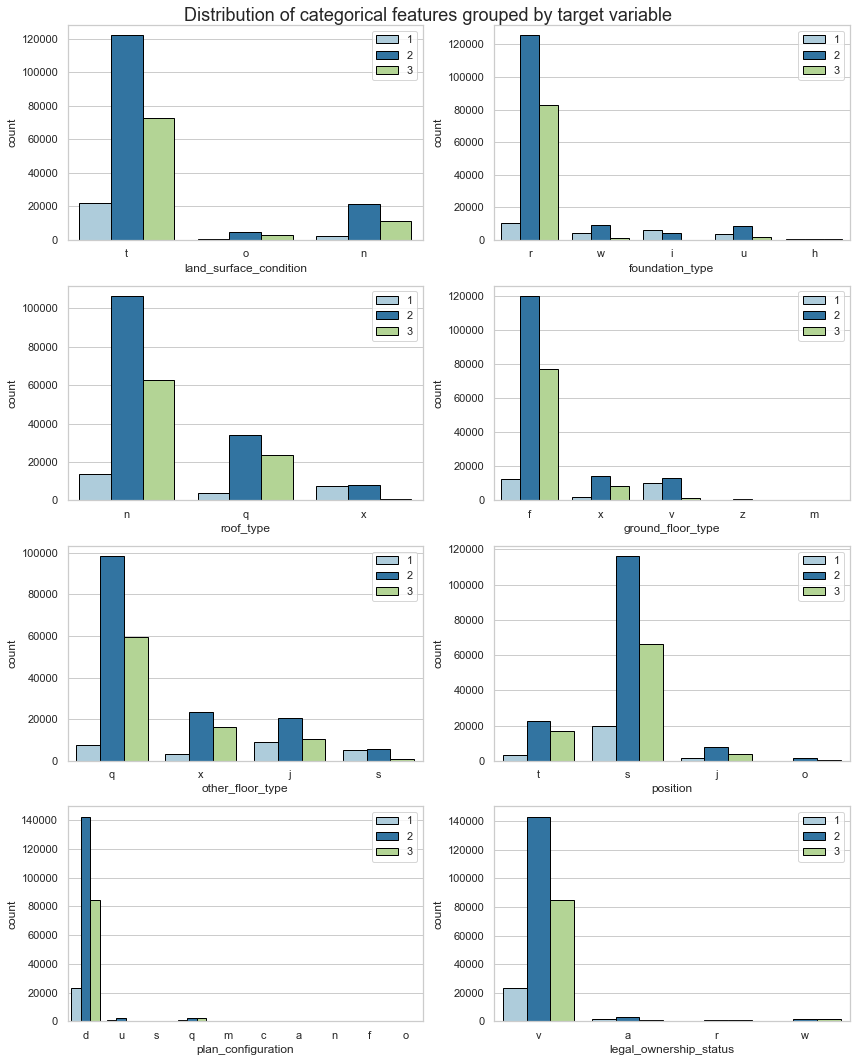

In [3]:
# First get columns to analyse (here: categorical ones)
categoric_columns = list(df_train.select_dtypes(include=['object']).columns)#.remove("building_id")
categoric_columns = categoric_columns + ["damage_grade"]
df_train_categoric = df_train[categoric_columns]
categoric_columns_wo_target = [x for x in categoric_columns if x != "damage_grade"]

# Dynamically set size of subplots
NCOLS: int = 2
NROWS: int = math.ceil(len(categoric_columns_wo_target)/NCOLS)

# Plot settings
fig, axes = plt.subplots(figsize=(12, 15), nrows=NROWS, ncols=NCOLS)
fig.suptitle("Distribution of categorical features grouped by target variable", size=18)
for feature, ax in zip(categoric_columns_wo_target, axes.flatten()):
    g=sns.countplot(data=df_train_categoric, x=feature, hue="damage_grade", edgecolor="black", ax=ax)
    ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

# Define mappings and map function

In [4]:
def group_categorical_features(df: pd.DataFrame, default_val: str = "others", verbose: bool = False) -> pd.DataFrame:
    """
    Function that groups categorical features with many unique low populated realizations into "others".
    Significant for feature that have rarely occurring categorical values, e.g. "plan_configuration".
    Predefined mappings are within the function and contain the column to apply the mapping and the map itself.
    Not explicitly listed mappings are replaced with param "default_val", which is "others" (default)

    :param df: DataFrame to apply the mapping
    :param default_val: Default value to use for not explicit listed maps
    :param verbose: Bool whether to print information or not (default: False)

    :return: DataFrame with the column replaced with the mapped column
    """

    # Define mapping for each feature with rarely occuring categorical values
    mapping_plan_configuration = {"col": "plan_configuration",
                                  "mapping": {"d": "d"}}
    mapping_legal_ownership_status = {"col": "legal_ownership_status",
                                      "mapping": {"v": "v"}}
    mapping_ground_floor_type = {"col": "ground_floor_type",
                                 "mapping": {"f": "f", "x": "x", "v": "v"}}
    # Put in list for iteration
    mappings = [mapping_plan_configuration, mapping_legal_ownership_status, mapping_ground_floor_type]

    # Apply mapping for each mapping defined in mappings list
    for mapping in mappings:
        # Overwrite column to be mapped with mapped values
        df[mapping.get("col")] = df[mapping.get("col")].map(mapping.get("mapping")).fillna(default_val)
        if verbose:
            print(f"Applied mapping / grouping for feature '{mapping.get('col')}'")
    return df

df = df_train.copy()
df = group_categorical_features(df=df, col="plan_configuration", default_val="others", verbose=True)

Applied mapping / grouping for feature: plan_configuration
Applied mapping / grouping for feature: legal_ownership_status
Applied mapping / grouping for feature: ground_floor_type


## Plot after Mapping

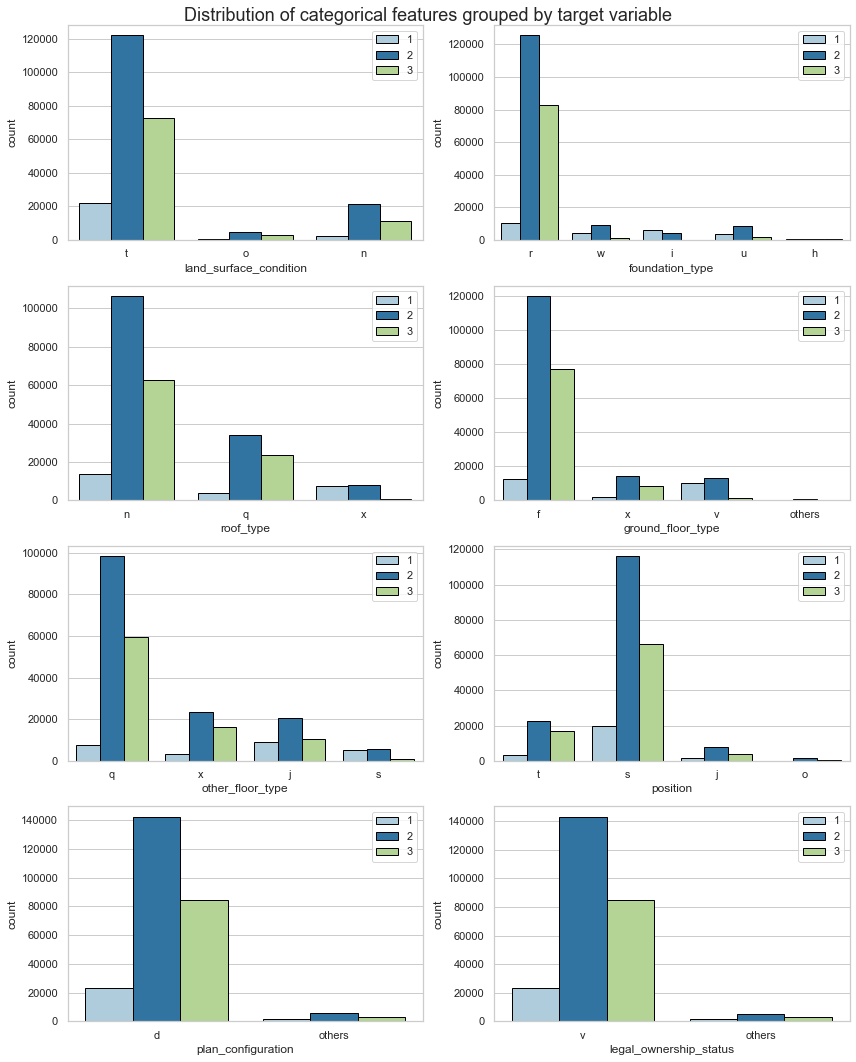

In [5]:
# Dynamically set size of subplots
NCOLS: int = 2
NROWS: int = math.ceil(len(categoric_columns_wo_target)/NCOLS)

# Plot settings
fig, axes = plt.subplots(figsize=(12, 15), nrows=NROWS, ncols=NCOLS)
fig.suptitle("Distribution of categorical features grouped by target variable", size=18)
for feature, ax in zip(categoric_columns_wo_target, axes.flatten()):
    g=sns.countplot(data=df, x=feature, hue="damage_grade", edgecolor="black", ax=ax)
    ax.legend(loc="upper right")
plt.tight_layout()
plt.show()